# Keras를 이용한 CNN 구현

### 이 실습의 목적
- Keras 프레임워크를 이용하여, CNN을 구현하고, 이를 이용하여 MNIST 데이터 셋을 분류하는 작업을 수행해봅니다.
- 이 실습을 통해 CNN의 기본적인 원리들을 간단하게 복습하고, Keras에 대한 기초적인 경험을 쌓을 수 있습니다.

### CNN이란

- Convolutional Neural Network의 약자로, convolution layer와 pooling layer 등을 이용하여 이미지, 오디오, 자연어 등을 처리하는 신경망 모델입니다.
- Convolution layer는 kernel이라고 불리는 필터를 이용하여 고차원 특징을 추출해내는 역할을 수행합니다.
- Pooling layer는 인접한 성분 중 가장 크거나, 인접한 성분의 평균 등만을 취합해 차원을 낮추어 복잡성을 줄이는 역할을 수행합니다.

### MNIST Database란

- MNIST database는 숫자 0부터 9까지의 손글씨 데이터로 이미지 인식 분야에서 널리 쓰이는 데이터셋 중 하나 입니다.
- 총 60000개의 이미지로 이루어져 있으며, 이 중 50,000개는 학습 데이터로, 나머지 10,000개는 테스트 데이터로 구성되어 있습니다.
- 각각의 이미지는 가로, 세로 28 픽셀씩, 총 784 픽셀로 이루어져 있습니다.

- 원래는 binary 파일로 이루어져 있지만 패키지의 함수를 이용해 쉽게 다뤄보도록 하겠습니다.

- 참고: [Yann LeCun 개인 홈페이지](http://yann.lecun.com/exdb/mnist/)

![MNIST database](./MNIST.jpg)

In [1]:
# 파이썬 버전 확인하기
import sys
print(sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


### 필요한 keras 모듈 / 패키지 가져오기

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

/Users/sangshinoh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 그 외 필요한 패키지 가져오기

In [3]:
import matplotlib.pyplot as plt
import os
import numpy as np

### 모델을 저장할 폴더 지정
- 분류기가 필요할 때마다 학습을 시킬 수 없기 때문에, 학습이 완료된 이후에는 학습된 파라미터들을 저장해야 합니다.
- 폴더를 하나 지정하고, 만약 해당 폴더가 현재 디렉토리 내에 없을 경우, 지정된 폴더를 현재 디렉토리 내에 만듭니다.
- 모델이 저장될 이름을 epoch 정보와, validation loss 정보와 함께 저장합니다.

In [ ]:
project_path = './model/'

if not os.path.exists(project_path):
    os.mkdir(project_path)
    
model_path = project_path + 'mnist-{epoch:02d}-{val_loss:.4f}.hdf5'

### 체크포인트 및 Early stopping 모델 저장하기

In [5]:
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### MNIST 데이터 셋 가져오기
- keras에 있는 mnist 모듈을 이용하여 불러오면 튜플 형태로 반환됩니다.
- 따라서 각각 train set, valdation set으로 나누고 각각의 데이터셋에서 입력 이미지와 출력 라벨로 구분해줍니다.

In [6]:
(X_train, Y_train), (X_validation, Y_validation) = mnist.load_data()

### 데이터 reshaping
- 입력 이미지의 경우, 784개의 픽셀 값이 벡터 형태로 나열돼 저장되어 있기 때문에 28\*28의 정사각형 형태로 바꿔줘야 합니다.
- 아래 코드에서 X_train.shape[0]은 이미지의 개수를, 맨 뒤의 1은 색 차원(RGB 등)을 의미합니다. MNIST 데이터는 그레이스케일 8비트 이미지이므로 색 차원이 1이고, 결과 값을 255로 나누어주게 됩니다.
- 출력 라벨은 0부터 9까지의 one-hot 벡터의 형태로 나타내주면 됩니다.

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_validation = X_validation.reshape(X_validation.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train, 10)
Y_validation = np_utils.to_categorical(Y_validation, 10)

### 모델 구성하기
- 우리가 구성할 모델은 다음과 같습니다.
    - (3, 3) 필터 32개로 구성된 첫번째 convolution layer
    - (3, 3) 필터 64개로 구성된 두번째 convolution layer
    - (2, 2) 구역에서 가장 큰 값만을 선택하는 maxpooling layer
    - drop out을 적용하고, tensor를 펼치는 layer
    - 각각 128, 10개의 unit을 가지는 2 층의 fully connected layer

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 학습하기
- 주어진 데이터를 이용해 모델을 학습시킵니다.
- 시간 관계상 5번만 돌리는 것으로 합시다.

In [10]:
history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), 
                    epochs=5, batch_size=200, verbose=0, callbacks=[checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.05146, saving model to ./model/mnist-01-0.0515.hdf5

Epoch 00002: val_loss improved from 0.05146 to 0.03732, saving model to ./model/mnist-02-0.0373.hdf5

Epoch 00003: val_loss improved from 0.03732 to 0.02979, saving model to ./model/mnist-03-0.0298.hdf5

Epoch 00004: val_loss improved from 0.02979 to 0.02928, saving model to ./model/mnist-04-0.0293.hdf5

Epoch 00005: val_loss improved from 0.02928 to 0.02864, saving model to ./model/mnist-05-0.0286.hdf5


In [11]:
print('\nAccuracy:{:.4f}'.format(model.evaluate(X_validation, Y_validation)[1]))

10000/10000 [==============================] - 6s 647us/step

Accuracy:0.9916


In [12]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

### Learning curve 그려보기
- 비록 epoch수가 적어 멋진 그래프는 얻을 수 없지만, 저장된 loss 값을 이용해 그래프를 그려봅시다.

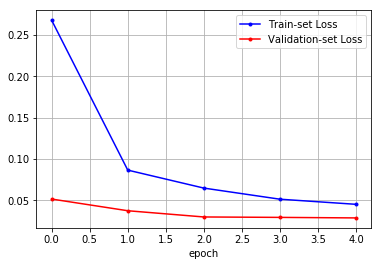

In [13]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()